# Encoder Decoder; Attention

https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

Lets test a few models on the first month of data, then run the full 5 months on the best

## Load data, functions

In [2]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import MultiHeadAttention, BatchNormalization, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pywt
import matrixprofile as mp
from keras import Model
from keras.layers import dot

In [2]:
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_start_ix = end_ix + n_step_lookahead -1
        out_end_ix = end_ix + n_steps_out + n_step_lookahead -1
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[out_start_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
#To demonstrate above function
sequence = range(0,13)
n_steps_in = 1
n_steps_in = 5
n_steps_out =1
step_interval =1
n_step_lookahead=5
split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead)

(array([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]]),
 array([[ 9],
        [10],
        [11],
        [12]]))

In [4]:
percentile_data = pd.read_csv (r'C:\Users/conal/Desktop/MCM/Practicum - Copy/data/block gas price percentile data.csv', header=0)
percentile_data['datetime'] = pd.to_datetime(percentile_data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')

percentile_data = percentile_data.sort_values(by='datetime',ascending=False)
percentile_data = percentile_data.set_index('datetime')
percentile_data = percentile_data.resample('5T').mean()
percentile_data = percentile_data/1000000000

In [5]:
usage_data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\ETH,gas,usage merged 11-26 to 05-26.csv', header=0)
usage_data['datetime'] = pd.to_datetime(usage_data['datetime'], format = '%Y-%m-%d %H:%M:%S')
usage_data = usage_data.set_index('datetime')

usage_data = usage_data.squeeze()
usage_data = usage_data.astype('float')
usage_data = usage_data.resample('5T').mean()

In [6]:
usage_data2 = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\Contract counts 2021-11-26 to 2022-05-26.csv', header=0, index_col=0)
usage_data2['datetime'] = pd.to_datetime(usage_data2['block_timestamp'], format = '%Y-%m-%d %H:%M:%S') 
usage_data2 = usage_data2.set_index('datetime')
usage_data2 = usage_data2.drop(['block_timestamp'], axis=1)
usage_data2 = usage_data2.squeeze()
usage_data2 = usage_data2.astype('float')
usage_data2 = usage_data2.resample('5T').sum()

In [7]:
data = usage_data.merge(percentile_data, left_index=True, right_index=True)
data = data.merge(usage_data2, left_index=True, right_index=True)

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [8]:
def generate_training_val_examples(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    scaler = StandardScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    #we are only lookign to forecast the min gas price
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))

    
    return X_train, y_train, X_val, y_val, scaler



In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


In [10]:
def descale_y_retrun_metrics(yhat, y_val2):
    #We will use validation data that has not had outleirs limited, will be a different min/max scaler as such
    dict_indexes=[]
    dict_dfs=[]
    for j in range(0, n_steps_out):
        RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
        for i in range(0, len(inputs)):  
            pred_descaled= (scaler.inverse_transform(yhat[:,j:j+1,:].reshape(yhat.shape[0], yhat.shape[2])))[:, i:i+1]
            groud_truth_descaled= ((scaler2.inverse_transform(y_val2[:,j:j+1,:].reshape(y_val2.shape[0], y_val2.shape[2]))))[:, i:i+1]
            RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
            MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
            MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
            MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
            R2 = r2_score(groud_truth_descaled, pred_descaled)
            RMSE_list.append(RMSE)
            MAE_list.append(MAE)
            MAPE_list.append(MAPE)
            R2_list.append(R2)
            MSE_list.append(MSE)
        metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=inputs)
        dict_dfs.append(metrics_df)
        dict_indexes.append('Lookahead' +str(j))
    metrics_dict = dict(zip(dict_indexes, dict_dfs))
    return metrics_dict

In [11]:
def generate_training_val_examples_univariate_output(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    scaler = StandardScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM, filter output to only the first input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))[:,:,:1]
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))[:,:,:1]

    
    return X_train, y_train, X_val, y_val, scaler

In [12]:
def descale_y_retrun_metrics_univariate_y(yhat, y_val2):
    #reverts standard scaling, returns dictionary of metrics for single output, for all lookaheads
    dict_indexes=[]
    dict_dfs=[]
    RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
    yhat_stretched= np.repeat(yhat[:,:,0],len(inputs)).reshape(yhat.shape[0], yhat.shape[1], len(inputs))
    y_val2_stretched= np.repeat(y_val2[:,:,0],len(inputs)).reshape(y_val2.shape[0], y_val2.shape[1], len(inputs))
    
    for j in range(0, n_steps_out):
        
        
        pred_descaled= (scaler.inverse_transform(yhat_stretched[:, j:j+1, :].reshape(yhat_stretched.shape[0], yhat_stretched.shape[2])))[:,:1]
        groud_truth_descaled= (scaler.inverse_transform(array([y_val2[ :, j:j+1,0].reshape(y_val2.shape[0])]*len(inputs)).transpose()))[:,:1]
        RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
        MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
        MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
        MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
        R2 = r2_score(groud_truth_descaled, pred_descaled)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        R2_list.append(R2)
        MSE_list.append(MSE)
    metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1, (n_steps_out+1)))

 
    return metrics_df

In [13]:
def add_mp_reversed(data, window):
    #Given 3d array, add matrix profile of (x,y,0) as new dimension; new array has dimensiosn (x,y,z+1) 
    mp_list=[]
    for i in data[:,:,0]:
        profile = mp.compute(np.flip(i, axis=0), window, n_jobs=4)['mp']
        #we are padding the end of the sequence with the mean
        #matrix profile is always 1 full window size smalelr than input data
        mp_list.append(np.append(profile,([mean(profile)]*(data.shape[1]-len(profile)))))
        
    #concatenate matrix profile data with original    
    mp_array = np.array(mp_list).reshape(data.shape[0], data.shape[1])
    std_array = ((mp_array-mean(mp_array))/np.std(mp_array)).reshape(data.shape[0], data.shape[1],1)
    data = np.concatenate((data, std_array), axis=2)
    
    return data

## Attention LSTM

Rough hyperparameter testing on first month of data

In [15]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'size', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4320
n_steps_out = 15
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window = 288

month=0
start_date=Start_dates[month]
end_date=end_dates[month]


In [16]:
mp_window=288
X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
#X_train = (add_mp_reversed(X_train, mp_window))[:,mp_window:,:]
#X_val = (add_mp_reversed(X_val, mp_window))[:,mp_window:,:]
#y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2])
#y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], y_val.shape[2])

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [200]:
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]-1))
output_train = Input(shape=(X_train.shape[1], X_train.shape[2]-1))



encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='tanh', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)

decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='tanh', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)

model = Model(inputs=input_train, outputs=out)



In [ ]:
n_hidden = 200
input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
output_train = Input(shape=(y_train.shape[1], y_train.shape[2]))





encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='tanh', dropout=0.2, 
    return_state=True, return_sequences=True,name='encoder')(input_train)



decoder_input = RepeatVector(output_train.shape[1],name='repeat_vector')(encoder_last_h)

decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
 return_state=False, return_sequences=True,name='decoder')(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name='attention_dot')
attention = Activation('softmax', name='attention_activation')(attention)

context = dot([attention, encoder_stack_h], axes=[2,1],name='Context')

decoder_combined_context = Concatenate(axis=2)([context, decoder_stack_h])

out = TimeDistributed(Dense(output_train.shape[2]))(context)

model = Model(inputs=input_train, outputs=out)

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
model.summary()

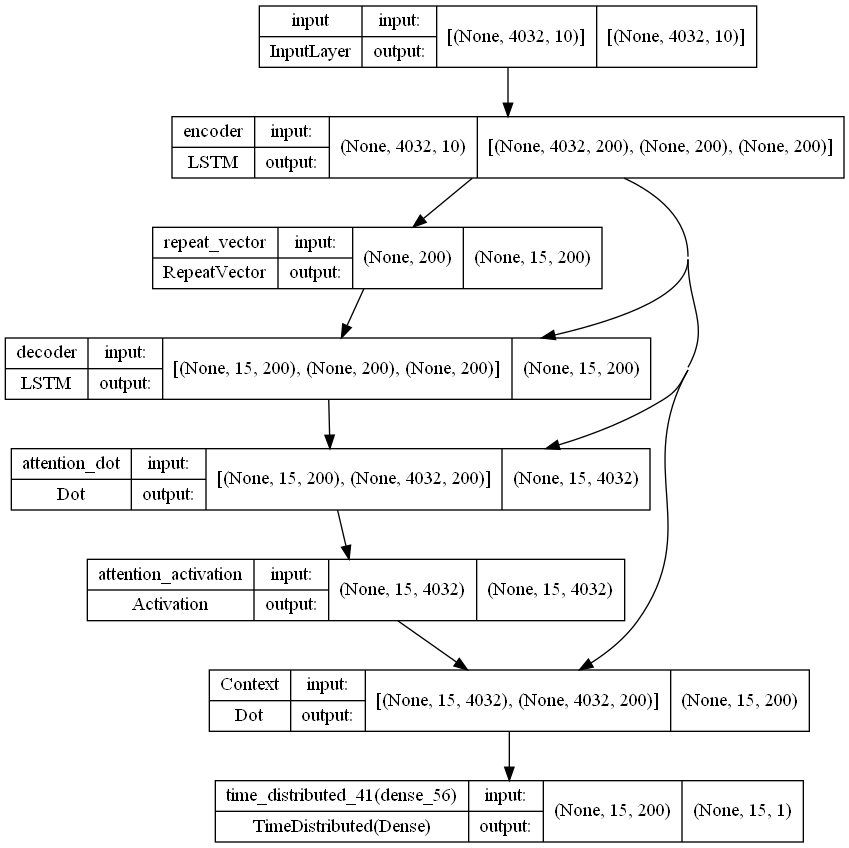

In [337]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [346]:
model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1)

Epoch 1/15
492/492 [==============================] - 151s 295ms/step - loss: 0.4016 - mae: 0.3347 - val_loss: 1.1312 - val_mae: 0.3144
Epoch 2/15
 53/492 [==>...........................] - ETA: 1:42 - loss: 0.3964 - mae: 0.3232

KeyboardInterrupt: 

In [339]:
yhat_train=model.predict(X_train, verbose=1)
yhat_val = model.predict(X_val, verbose=1)
    


44/44 [==============================] - 4s 101ms/step


In [340]:
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))



## Longer Lookahead

In [341]:
training_metrics_dicts

[         RMSE          MSE        MAE      MAPE        R2
 1   26.025717   677.337921  10.305420  0.131118  0.639572
 2   28.258194   798.525540  11.976923  0.152382  0.574910
 3   29.092051   846.347453  12.949673  0.165970  0.549150
 4   29.832153   889.957347  13.443774  0.172522  0.525834
 5   30.324368   919.567273  13.596614  0.175107  0.510001
 6   30.431417   926.071128  13.595442  0.175728  0.506504
 7   30.579869   935.128412  13.672235  0.177125  0.501489
 8   30.739379   944.909421  13.766863  0.178925  0.496174
 9   30.804452   948.914254  13.891704  0.180997  0.493964
 10  30.823927   950.114458  13.994564  0.182976  0.493318
 11  31.060362   964.746077  14.183363  0.185948  0.485447
 12  31.316632   980.731463  14.364038  0.188849  0.476872
 13  31.715111  1005.848260  14.687792  0.193089  0.463425
 14  32.202230  1036.983639  15.013763  0.197098  0.446783
 15  32.788398  1075.079045  15.400085  0.201558  0.426364]

In [342]:
valdiation_metrics_dicts

[         RMSE         MSE        MAE      MAPE        R2
 1   15.745903  247.933476   9.894911  0.127353  0.551198
 2   17.309433  299.616468  10.765267  0.139590  0.458438
 3   18.008613  324.310147  11.272753  0.148042  0.413861
 4   18.491014  341.917589  11.779972  0.156665  0.382034
 5   18.858211  355.632138  12.123609  0.162897  0.357230
 6   19.083360  364.174621  12.405016  0.168225  0.341818
 7   19.182840  367.981361  12.524401  0.171524  0.334918
 8   19.242145  370.260144  12.616712  0.174134  0.330739
 9   19.320600  373.285584  12.730713  0.176921  0.325142
 10  19.433224  377.650187  12.851777  0.179630  0.317055
 11  19.477404  379.369279  12.879721  0.181171  0.313842
 12  19.527593  381.326871  12.943865  0.183079  0.310045
 13  19.531122  381.464719  12.941786  0.183878  0.309825
 14  19.529881  381.416252  13.015962  0.185878  0.310553
 15  19.530657  381.446559  13.085035  0.187291  0.310765]

## Batch Normalization + 200 hidden

In [315]:
training_metrics_dicts

[        RMSE          MSE        MAE      MAPE        R2
 1  27.372008   749.226843  13.004301  0.176288  0.600523
 2  31.415444   986.930102  15.423984  0.208229  0.473570
 3  32.316433  1044.351812  16.349033  0.221919  0.442607
 4  33.110901  1096.331769  17.138189  0.234425  0.414795
 5  34.325391  1178.232457  17.901585  0.246461  0.371076]

In [316]:
valdiation_metrics_dicts

[        RMSE         MSE        MAE      MAPE        R2
 1  13.922585  193.838375   8.734242  0.124335  0.648961
 2  17.073722  291.511998  10.924657  0.153643  0.472129
 3  18.633802  347.218561  12.336426  0.173867  0.371176
 4  19.244081  370.334651  13.094953  0.187173  0.329728
 5  19.597376  384.057141  13.675414  0.197946  0.304881]

## 200 hidden ***

In [306]:
training_metrics_dicts

[        RMSE         MSE        MAE      MAPE        R2
 1  25.955085  673.666429   9.531117  0.117856  0.640811
 2  28.348174  803.618946  12.000904  0.148661  0.571349
 3  29.711282  882.760255  13.030442  0.161426  0.528852
 4  30.627722  938.057383  13.711982  0.168999  0.499280
 5  31.307164  980.138529  14.203849  0.173941  0.476816]

In [307]:
valdiation_metrics_dicts

[        RMSE         MSE        MAE      MAPE        R2
 1  12.624890  159.387854   7.937724  0.109418  0.711351
 2  14.967525  224.026804   9.409025  0.130552  0.594332
 3  15.926301  253.647077  10.135774  0.139871  0.540637
 4  16.463512  271.047239  10.606332  0.146606  0.509429
 5  16.897997  285.542307  10.955312  0.151366  0.483187]

## 100 hidden

In [294]:
training_metrics_dicts

[        RMSE          MSE        MAE      MAPE        R2
 1  26.891660   723.161372  10.784685  0.152176  0.614421
 2  30.479887   929.023523  12.871599  0.176672  0.504458
 3  31.114880   968.135728  13.829383  0.191018  0.483286
 4  31.391028   985.396670  14.530961  0.200327  0.474011
 5  31.923218  1019.091863  15.085831  0.207604  0.456023]

In [295]:
valdiation_metrics_dicts

[        RMSE         MSE        MAE      MAPE        R2
 1  14.201220  201.674644   9.335226  0.140333  0.634770
 2  15.939422  254.065165  10.318553  0.151945  0.539938
 3  16.714763  279.383288  10.858177  0.159221  0.494028
 4  17.098453  292.357086  11.198643  0.164113  0.470860
 5  17.370116  301.720940  11.506529  0.168700  0.453904]

## Lets test across all months with a lookahead of 10

In [15]:
def LSTM_model():
    
    checkpoint_filepath='./cnn/checkpoint'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    n_hidden = 200
    input_train = Input(shape=(n_steps_in, X_train.shape[2]),name='input')
    output_train = Input(shape=(y_train.shape[1], y_train.shape[2]))





    encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='tanh', dropout=0.2, 
    return_state=True, return_sequences=True,name='encoder')(input_train)



    decoder_input = RepeatVector(output_train.shape[1],name='repeat_vector')(encoder_last_h)

    decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2,
     return_state=False, return_sequences=True,name='decoder')(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

    attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2], name='attention_dot')
    attention = Activation('softmax', name='attention_activation')(attention)

    context = dot([attention, encoder_stack_h], axes=[2,1],name='Context')

    decoder_combined_context = Concatenate(axis=2)([context, decoder_stack_h])

    out = TimeDistributed(Dense(output_train.shape[2]))(context)

    model = Model(inputs=input_train, outputs=out)

    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    return model, model_checkpoint_callback, checkpoint_filepath

In [18]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#end_dates = ['2022-01-26 23:55:00', '2022-03-26 23:55:00']
#Start_dates = ['2021-11-26 00:00:00', '2022-01-26 00:00:00']
inputs = ['min_gas_price', 'block_gas_5th_percentile', 'block_gas_95th_percentile', 'gas_used', 'base_fee_per_gas', 'transaction_count', 'size', 'Open', 'contracts']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 4032
n_steps_out = 10
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1
mp_window = 288



y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_step_lookahead = 1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    X_train = add_mp_reversed(X_train, mp_window)
    X_val = add_mp_reversed(X_val, mp_window)
    

    
    
    model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
    train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
    train_loss_list.append(train_history.history['loss'])
    val_loss_list.append(train_history.history['val_loss'])
    model.load_weights(checkpoint_filepath)
    model.save(('Encoder_Decoder_5/Month' +str(month)))
    
    yhat_train=model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)
    
    training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
    valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))

    pd.DataFrame(train_loss_list).to_csv('Encoder_Decoder_5/train_loss')
    pd.DataFrame(val_loss_list).to_csv('Encoder_Decoder_5/val_loss')
    np.save("Encoder_Decoder_5/validation_metric_dict_1.npy", valdiation_metrics_dicts)
    np.save("Encoder_Decoder_5/training_metric_dict_1.npy", training_metrics_dicts)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 35s 285ms/step - loss: 0.3618 - mae: 0.2542 - val_loss: 0.0720 - val_mae: 0.1713
Epoch 2/15
107/107 [==============================] - 30s 277ms/step - loss: 0.3373 - mae: 0.2309 - val_loss: 0.0583 - val_mae: 0.1558
Epoch 3/15
107/107 [==============================] - 29s 274ms/step - loss: 0.3308 - mae: 0.2298 - val_loss: 0.0593 - val_mae: 0.1591
Epoch 4/15
107/107 [==============================] - 29s 275ms/step - loss: 0.3257 - mae: 0.2293 - val_loss: 0.0557 - val_mae: 0.1555
Epoch 5/15
107/107 [==============================] - 29s 276ms/step - loss: 0.3131 - mae: 0.2200 - val_loss: 0.0537 - val_mae: 0.1566
Epoch 6/15
107/107 [==============================] - 29s 274ms/step - loss: 0.3156 - mae: 0.2197 - val_loss: 0.0585 - val_mae: 0.1645
Epoch 7/15
107/107 [==============================] - 29s 272ms/step - loss: 0.3102 - mae: 0.2205 - val_loss: 0.0571 - val_mae: 0.1485
Epoch 8/15
107/107 [==============================] - 2

INFO:tensorflow:Assets written to: Encoder_Decoder_5/Month0\assets


INFO:tensorflow:Assets written to: Encoder_Decoder_5/Month0\assets


46/46 [==============================] - 5s 99ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
114/114 [==============================] - 37s 282ms/step - loss: 0.6380 - mae: 0.4387 - val_loss: 0.4427 - val_mae: 0.4246
Epoch 2/15
114/114 [==============================] - 31s 272ms/step - loss: 0.5613 - mae: 0.3995 - val_loss: 0.6942 - val_mae: 0.5716
Epoch 3/15
114/114 [==============================] - 31s 273ms/step - loss: 0.5464 - mae: 0.3908 - val_loss: 0.4299 - val_mae: 0.3904
Epoch 4/15
114/114 [==============================] - 31s 271ms/step - loss: 0.5426 - mae: 0.3908 - val_loss: 0.5303 - val_mae: 0.4641
Epoch 5/15
114/114 [==============================] - 31s 273ms/step - loss: 0.5195 - mae: 0.3822 - val_loss: 0.4299 - val_mae: 0.3882
Epoch 6/15
114/114 [==============================] - 31s 274ms/step - loss: 0.5144 - mae: 0.3770 - val_loss: 0.4922 - val_mae: 0.4208
Epoch 7/15
114/114 [==============================] - 31s 273ms/step - loss: 0.5268 - mae: 0.3875 - val_loss: 0.4744 - val_mae: 0.4099
Epoch 8/15
114/114 [==============================] - 3

INFO:tensorflow:Assets written to: Encoder_Decoder_5/Month1\assets


INFO:tensorflow:Assets written to: Encoder_Decoder_5/Month1\assets


49/49 [==============================] - 5s 99ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 35s 283ms/step - loss: 0.2616 - mae: 0.2442 - val_loss: 0.3391 - val_mae: 0.2715
Epoch 2/15
107/107 [==============================] - 29s 273ms/step - loss: 0.2431 - mae: 0.2279 - val_loss: 0.3386 - val_mae: 0.2607
Epoch 3/15
107/107 [==============================] - 29s 273ms/step - loss: 0.2345 - mae: 0.2209 - val_loss: 0.3300 - val_mae: 0.2745
Epoch 4/15
107/107 [==============================] - 29s 271ms/step - loss: 0.2332 - mae: 0.2205 - val_loss: 0.3422 - val_mae: 0.2826
Epoch 5/15
107/107 [==============================] - 29s 275ms/step - loss: 0.2252 - mae: 0.2143 - val_loss: 0.3415 - val_mae: 0.3013
Epoch 6/15
107/107 [==============================] - 29s 271ms/step - loss: 0.2254 - mae: 0.2177 - val_loss: 0.3318 - val_mae: 0.2633
Epoch 7/15
107/107 [==============================] - 29s 274ms/step - loss: 0.2125 - mae: 0.2131 - val_loss: 0.3285 - val_mae: 0.2701
Epoch 8/15
107/107 [==============================] - 2

INFO:tensorflow:Assets written to: Encoder_Decoder_5/Month2\assets


INFO:tensorflow:Assets written to: Encoder_Decoder_5/Month2\assets


46/46 [==============================] - 5s 100ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
88/88 [==============================] - 29s 286ms/step - loss: 0.2048 - mae: 0.1870 - val_loss: 0.0549 - val_mae: 0.1639
Epoch 2/15
88/88 [==============================] - 24s 273ms/step - loss: 0.1765 - mae: 0.1556 - val_loss: 0.0452 - val_mae: 0.1545
Epoch 3/15
88/88 [==============================] - 24s 268ms/step - loss: 0.1718 - mae: 0.1504 - val_loss: 0.0463 - val_mae: 0.1510
Epoch 4/15
88/88 [==============================] - 24s 271ms/step - loss: 0.1679 - mae: 0.1423 - val_loss: 0.0400 - val_mae: 0.1301
Epoch 5/15
88/88 [==============================] - 24s 269ms/step - loss: 0.1691 - mae: 0.1420 - val_loss: 0.0463 - val_mae: 0.1702
Epoch 6/15
88/88 [==============================] - 24s 271ms/step - loss: 0.1611 - mae: 0.1399 - val_loss: 0.0465 - val_mae: 0.1427
Epoch 7/15
88/88 [==============================] - 24s 268ms/step - loss: 0.1648 - mae: 0.1445 - val_loss: 0.0405 - val_mae: 0.1311
Epoch 8/15
88/88 [==============================] - 23s 268ms/step - 

INFO:tensorflow:Assets written to: Encoder_Decoder_5/Month3\assets


INFO:tensorflow:Assets written to: Encoder_Decoder_5/Month3\assets


38/38 [==============================] - 5s 100ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
107/107 [==============================] - 35s 282ms/step - loss: 0.1058 - mae: 0.1795 - val_loss: 0.0511 - val_mae: 0.1606
Epoch 2/15
107/107 [==============================] - 29s 269ms/step - loss: 0.0814 - mae: 0.1504 - val_loss: 0.0574 - val_mae: 0.1908
Epoch 3/15
107/107 [==============================] - 29s 273ms/step - loss: 0.0837 - mae: 0.1499 - val_loss: 0.0461 - val_mae: 0.1567
Epoch 4/15
107/107 [==============================] - 29s 274ms/step - loss: 0.0691 - mae: 0.1377 - val_loss: 0.0410 - val_mae: 0.1390
Epoch 5/15
107/107 [==============================] - 29s 269ms/step - loss: 0.0714 - mae: 0.1365 - val_loss: 0.0436 - val_mae: 0.1511
Epoch 6/15
107/107 [==============================] - 29s 274ms/step - loss: 0.0758 - mae: 0.1398 - val_loss: 0.0531 - val_mae: 0.1791
Epoch 7/15
107/107 [==============================] - 29s 271ms/step - loss: 0.0709 - mae: 0.1384 - val_loss: 0.0486 - val_mae: 0.1497
Epoch 8/15
107/107 [==============================] - 2

INFO:tensorflow:Assets written to: Encoder_Decoder_5/Month4\assets


INFO:tensorflow:Assets written to: Encoder_Decoder_5/Month4\assets


46/46 [==============================] - 5s 101ms/step


In [3]:
np.load('Encoder_Decoder_5/validation_metric_dict_1.npy', allow_pickle=True)

array([[[1.50896535e+01, 2.27697643e+02, 1.04049353e+01, 1.57993216e-01,
         6.02255704e-01],
        [1.59786283e+01, 2.55316564e+02, 1.03799963e+01, 1.49508432e-01,
         5.53992422e-01],
        [1.65360266e+01, 2.73440175e+02, 1.07483683e+01, 1.53305216e-01,
         5.22360082e-01],
        [1.68818799e+01, 2.84997870e+02, 1.10795225e+01, 1.58644371e-01,
         5.02033188e-01],
        [1.71401953e+01, 2.93786293e+02, 1.14217561e+01, 1.64598393e-01,
         4.86294811e-01],
        [1.73275194e+01, 3.00242928e+02, 1.16990991e+01, 1.69522384e-01,
         4.74777258e-01],
        [1.74711296e+01, 3.05240371e+02, 1.19438274e+01, 1.73403220e-01,
         4.66101376e-01],
        [1.75766378e+01, 3.08938196e+02, 1.21387999e+01, 1.76486564e-01,
         4.59766884e-01],
        [1.77101607e+01, 3.13649791e+02, 1.23351366e+01, 1.79609337e-01,
         4.51749149e-01],
        [1.78701426e+01, 3.19341996e+02, 1.25370132e+01, 1.82651055e-01,
         4.42046489e-01]],

       [